## Analyse d'ombre sur un établissement de St denis

### Imports

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
from shapely.affinity import translate
from shapely.ops import unary_union
from shapely import intersection
from pathlib import Path
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore') 

### Chargement des Bâtiments et Zones Éducatives

In [3]:
DATA_FOLDER = Path("../data")

saint_denis_path = DATA_FOLDER / "saint_denis_reference_data.gpkg"

ecoles = gpd.read_file(saint_denis_path, layer="bdtopo_education").to_crs(2154)
batiments = gpd.read_file(saint_denis_path, layer="bdtopo_batiment").to_crs(2154)

### Préparation des données pour l'analyse des ombres

In [4]:

ecole_cible = ecoles.iloc[[6]]  # On prend la 6ème école par exemple

#Vérification de la hauteur 
if "hauteur" in batiments.columns:
    hauteur_ecole = batiments.loc[batiments["cleabs_right__bat"] == ecole_cible["cleabs_right"].iloc[0], "hauteur"]
    if not hauteur_ecole.empty:
        hauteur_ecole = float(hauteur_ecole.iloc[0])
    else:
        raise ValueError("None")
else:
    raise KeyError("None")


batiments["distance"] = batiments.geometry.distance(ecole_cible.geometry.iloc[0])

rayon = 100  #rayon de 100m
batiments_voisins = batiments[batiments["distance"] < rayon].copy()

batiments_voisins["hauteur"] = pd.to_numeric(batiments_voisins["hauteur"], errors="coerce")

batiments_plus_hauts = batiments_voisins[batiments_voisins["hauteur"] > hauteur_ecole]

### Calcul de l'ombre projetée en fonction des 4 jours clés

In [5]:

saisons = {
    "hiver": 15,       # Soleil bas en hiver (21 décembre)
    "printemps": 45,   # Équinoxe (21 mars)
    "été": 75,         # Soleil haut en été (21 juin)
    "automne": 45      # Équinoxe (21 septembre)
}

jours_cles = ["hiver", "printemps", "été", "automne"]

### Visualisation comprenant les ombres des bâtiment voisins sur les toits (non sur le sol)

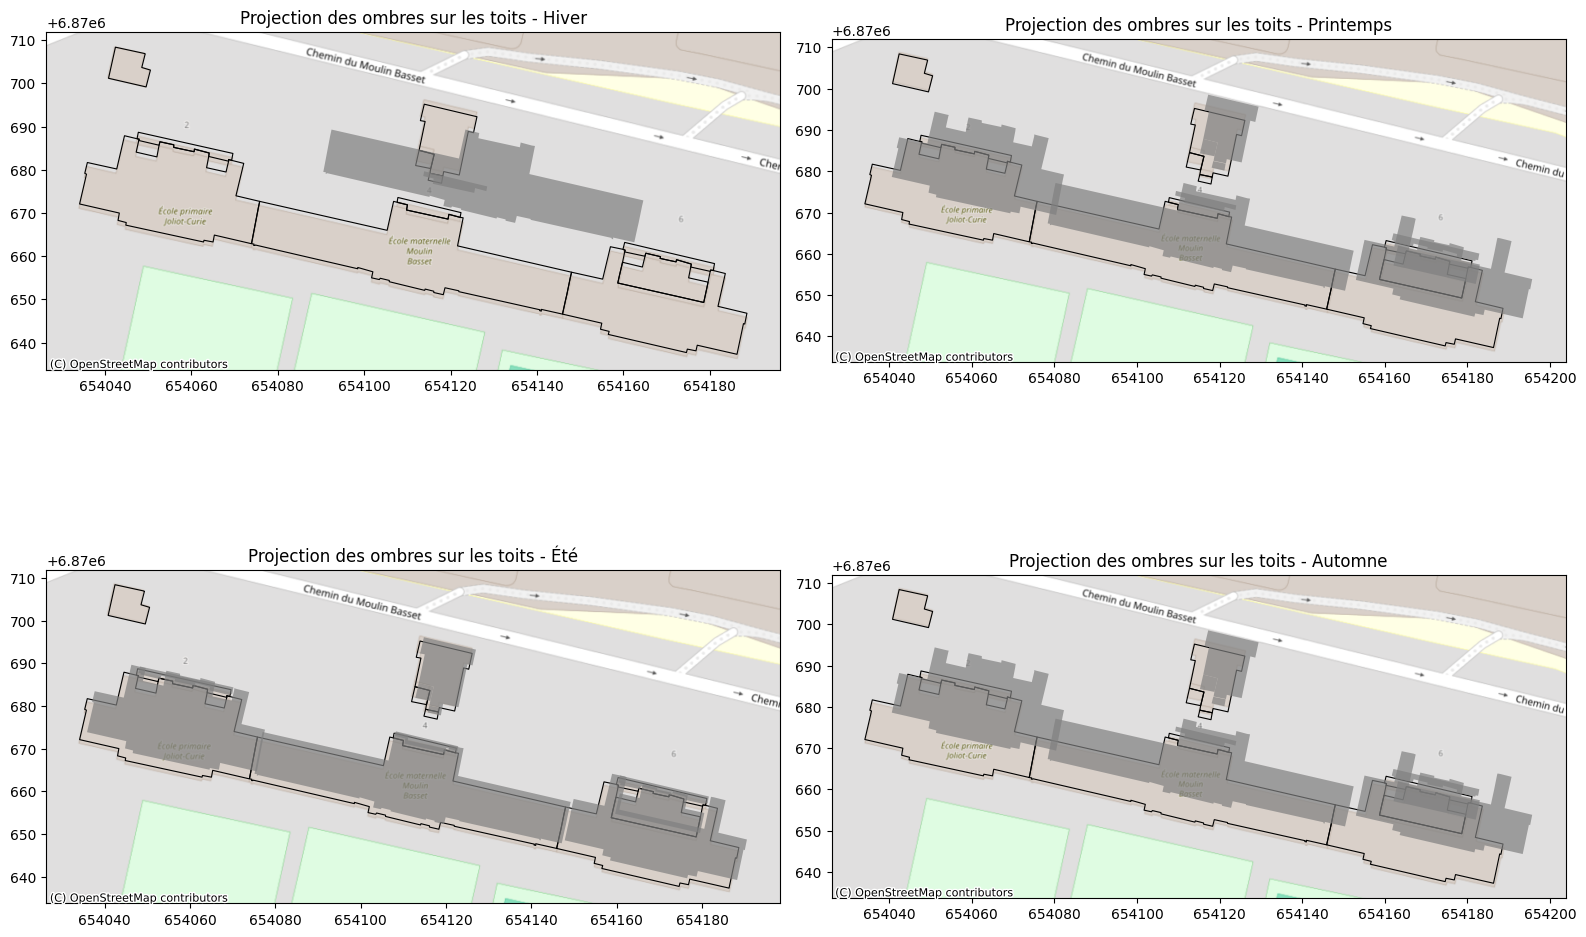

In [6]:

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, saison in enumerate(jours_cles):
    angle_solaire = np.radians(saisons[saison])
    ombres_toit = []
    
    for _, row in batiments_plus_hauts.iterrows():
        hauteur_relative = row["hauteur"] - hauteur_ecole
        distance_ombre = hauteur_relative / np.tan(angle_solaire)
        
        
        deplacement_x = distance_ombre * np.cos(np.radians(45))
        deplacement_y = distance_ombre * np.sin(np.radians(45))
        ombre_projetee = translate(row["geometry"], xoff=deplacement_x, yoff=deplacement_y)
        
        
        instn = batiments_voisins.intersects(ombre_projetee)
        if instn.any():
            ombres_toit.append(ombre_projetee)
    
    ombre_toit_gdf = gpd.GeoDataFrame(geometry=ombres_toit, crs=2154)
    
    batiments_voisins.plot(ax=axes[i], color="none", edgecolor="black", linewidth=0.8)
    ombre_toit_gdf.plot(ax=axes[i], color="grey", alpha=0.7, label=f"Ombres sur toits - {saison}")
    cx.add_basemap(axes[i], crs=batiments_voisins.crs, source=cx.providers.OpenStreetMap.Mapnik)
    axes[i].set_title(f"Projection des ombres sur les toits - {saison.capitalize()}")

plt.tight_layout()
plt.show()


# Proposition d'ajustement

In [7]:
ecoles = gpd.read_file(saint_denis_path, layer="bdtopo_education").to_crs(2154)
batiments = gpd.read_file(saint_denis_path, layer="bdtopo_batiment").to_crs(2154)
ecole_cible = ecoles.iloc[[6]]  # On prend la 6ème école par exemple
id = ecole_cible["cleabs_left"].iloc[0] # id de la surface
zone = ecole_cible["geometry"].iloc[0]
print(id)

SURFACTI0000000002555648


<Axes: >

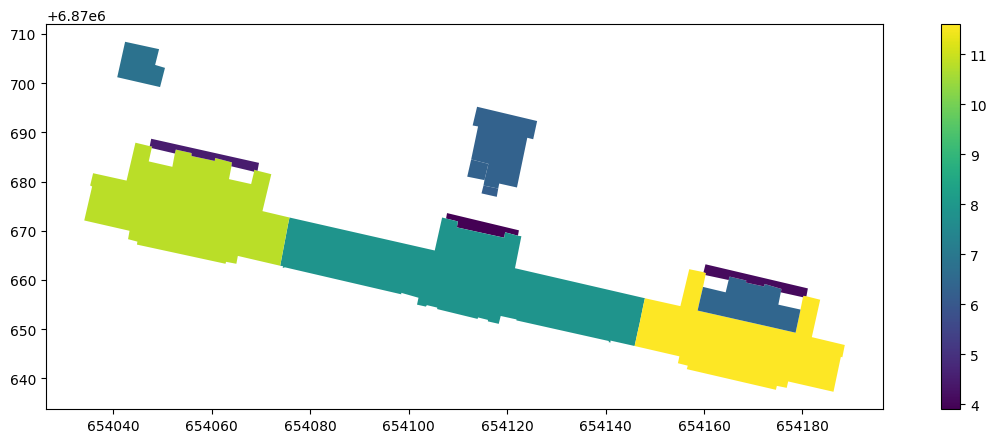

In [8]:
batiments_ecole = batiments[batiments.within(zone)]
hauteur_moyenne = batiments_ecole['hauteur'].mean() 
if hauteur_moyenne > 0:
    batiments_ecole.fillna(value=hauteur_moyenne, inplace=True) 
else:
    raise KeyError("None")

batiments_ecole.plot(column="hauteur",legend=True,figsize=(15,5))

@TODO: les batiments proches peuvent etre des batiments qui ne sont pas du fichier écoles. Ici, ne sont pas pris en compte les batiments autres que zone éducative, il faudrait donc élargir la recherche à la BDD bâtiments initiale.

Par conséquent, le travail sur les ombres va être fait sur uniquement les batiments de l'école qui font de l'ombre aux autres batiments de l'école.

<Axes: >

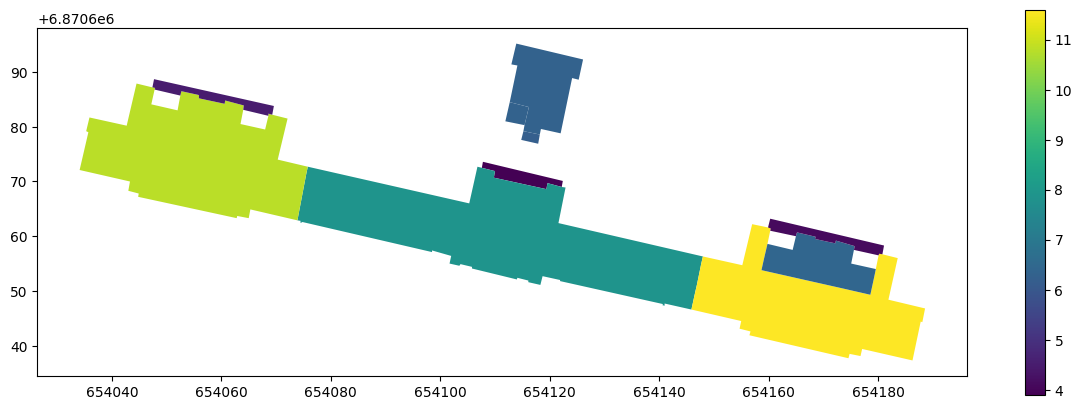

In [9]:
batiments_proches = batiments[batiments.within(zone.buffer(100))]
batiments_proches.plot(column="hauteur",legend=True,figsize=(15,5))

In [20]:
def getOmbre(ombres_potentielles, h, shape_batiment,resolution=10):
    ombres_toit = []
    for i, saison in enumerate(jours_cles):
        angle_solaire = np.radians(saisons[saison])
        for _, row in ombres_potentielles.iterrows():
            hauteur_relative = row["hauteur"] - h
            distance_ombre = hauteur_relative / np.tan(angle_solaire)

            # @TODO: pourquoi hardcoder 45 ci-dessous?
            deplacement_x = distance_ombre * np.cos(np.radians(45))
            deplacement_y = distance_ombre * np.sin(np.radians(45))
            ombre_projetee = []
            for r in range(resolution+1):
                ombre_projetee.append(translate(row["geometry"], xoff=r*deplacement_x/resolution, yoff=r*deplacement_y/resolution))
            ombre_projetee = unary_union(ombre_projetee)
            ombrage = intersection(shape_batiment,ombre_projetee)
            ombres_toit.append(ombrage)
    ombres_toit = unary_union(ombres_toit)

    return ombres_toit

In [53]:
ombres = []
for ix, row in batiments_ecole.iterrows():
    h = row["hauteur"]
    i = row["cleabs_left__bat"]
    shape_batiment = row["geometry"]
    ombres_potentielles = batiments_ecole[(batiments_ecole.hauteur > h)]
    ombres_potentielles_shapes = getOmbre(ombres_potentielles, h, shape_batiment,resolution=10)
    if not ombres_potentielles_shapes.is_empty:
        ombres.append(ombres_potentielles_shapes)    
ombres = unary_union(ombres)
ombres = gpd.GeoDataFrame(geometry=[ombres], crs=2154)
ombres["geometries"] = ombres.apply(lambda x: [g for g in x.geometry.geoms], axis=1)
ombres = ombres.explode(column="geometries").drop(columns="geometry").set_geometry("geometries").rename_geometry("geometry")

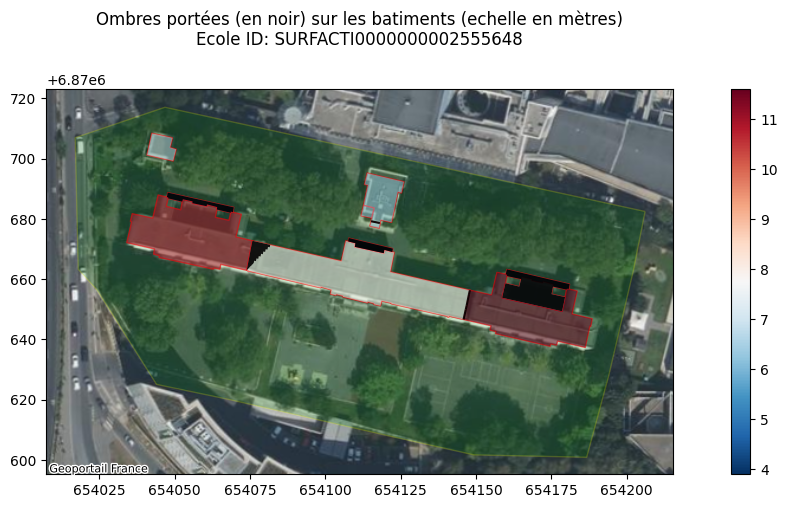

In [60]:
fig, ax = plt.subplots(figsize=(15,5))

ecole_cible.plot(ax=ax, alpha=0.2, color ="green", edgecolor='yellow')
batiments_ecole.plot(ax=ax, alpha=0.6, linewidth=1,facecolor="none", edgecolor='red', label="batiments")
batiments_ecole.plot(ax=ax, alpha=0.5,column="hauteur",legend=True,figsize=(15,5),cmap="RdBu_r")
ombres.plot(ax=ax, alpha=0.9, color ="black")
ax.set_title("Ombres portées (en noir) sur les batiments (echelle en mètres)\nEcole ID: "+id+"\n") 
cx.add_basemap(ax, crs=ecole_cible.crs, source=cx.providers.GeoportailFrance.orthos )
fig.show()